# Benchmarking Behavior Planners in BARK

This notebook the benchmarking workflow of BARK.

Systematically benchmarking behavior consists of
1. A reproducable set of scenarios (we call it **BenchmarkDatabase**)
2. Metrics, which you use to study the performance (we call it **Evaluators**)
3. The behavior model(s) under test

Our **BenchmarkRunner** can then run the benchmark and produce the results.

TODO

Explain BenchmarkDatabase and runner
run benchmark
small evaluation

use the example python agent of previous tutorial to benchmark and compare it against idm model (python system test behavior model + benchmark runner test) (Klemens)

In [10]:
import os
import matplotlib.pyplot as plt

from load.benchmark_database import BenchmarkDatabase
from serialization.database_serializer import DatabaseSerializer
from modules.benchmark.benchmark_runner import BenchmarkRunner, BenchmarkConfig, BenchmarkResult
from modules.benchmark.benchmark_analyzer import BenchmarkAnalyzer

from modules.runtime.commons.parameters import ParameterServer

from modules.runtime.viewer.matplotlib_viewer import MPViewer

from bark.models.behavior import BehaviorIDMClassic, BehaviorConstantVelocity

# Database
The benchmark database provides a reproducable set of scenarios.
A scenario get's created by a ScenarioGenerator (we have a couple of them). The scenarios are serialized into binary files (ending `.bark_scenarios`) and packed together with the map file and the parameter files into a `.zip`-archive. We call this zipped archive a relase, which can be published at Github, or processed locally.

## We will first start with the DatabaseSerializer

The **DatabaseSerializer** recursively serializes all scenario param files sets
 within a folder.

In [2]:
os.chdir("../../../benchmark_database/")
os.listdir()

['database', 'serialization', '__init__.py', 'load']

process the database directory

In [3]:
dbs = DatabaseSerializer(test_scenarios=4, test_world_steps=5, num_serialize_scenarios=10)
dbs.process("database")
local_release_filename = dbs.release(version="tutorial")

print('Filename:', local_release_filename)

INFO:root:Testing test_1 with seed 1000 from generator ConfigurableScenarioGeneration
INFO:root:Running scenario 9 of 10 in set test_1
INFO:root:Running scenario 8 of 10 in set test_1
INFO:root:Running scenario 0 of 10 in set test_1
INFO:root:Running scenario 8 of 10 in set test_1
INFO:root:The following list of files will be released:
INFO:root:database/maps/city_highway_straight.xodr
INFO:root:database/scenario_sets/highway_merging/test_1_scenarios10_seed1000.bark_scenarios
INFO:root:database/scenario_sets/highway_merging/test_1.json
INFO:root:database/scenario_sets/highway_merging/test_2.json
INFO:root:database/scenario_sets/highway_merging/set_info_test_1
INFO:root:Packed release file /home/esterle/.cache/bazel/_bazel_esterle/d337abac8c371120c1b9affa1049fa7e/execroot/bark_project/bazel-out/k8-fastbuild/bin/docs/tutorials/run.runfiles/benchmark_database/database/benchmark_database_tutorial.zip
INFO:root:Assuming local release as you did not provide a github token.


Filename: database/benchmark_database_tutorial.zip


Then reload to test correct parsing

In [4]:
db = BenchmarkDatabase(database_root=local_release_filename)
scenario_generation, _ = db.get_scenario_generator(scenario_set_id=0)

for scenario_generation, _ in db:
  print('Scenario: ', scenario_generation)

INFO:root:extracting zipped-database database/benchmark_database_tutorial.zip to temporary directory /tmp/database
INFO:root:Found info dict set_info_test_1
INFO:root:The following scenario sets are available
INFO:root:
                    GeneratorName  NumScenarios                                             Params    Seed                                         Serialized SetName
0  ConfigurableScenarioGeneration          10.0  database/scenario_sets/highway_merging/test_1....  1000.0  database/scenario_sets/highway_merging/test_1_...  test_1


Scenario:  <modules.runtime.scenario.scenario_generation.scenario_generation.ScenarioGeneration object at 0x7f55cbdb00d0>


## Evaluators

Evaluators allow to calculate a boolean, integer or real-valued metric based on the current simulation world state.

The current evaluators available in BARK are:
- StepCount: returns the step count the scenario is at.
- GoalReached: checks if a controlled agent’s Goal Definitionis satisfied.
- DrivableArea: checks whether the agent is inside its RoadCorridor.
- Collision(ControlledAgent): checks whether any agent or only the currently controlled agent collided

Let's now map those evaluators to some symbols, that are easier to interpret.

In [5]:
evaluators = {"success" : "EvaluatorGoalReached", \
              "collision" : "EvaluatorCollisionEgoAgent", \
              "max_steps": "EvaluatorStepCount"}

We will now define the terminal conditions of our benchmark. We state that a scenario ends, if
- a collision occured
- the number of time steps exceeds the limit
- the definition of success becomes true (which we defined to reaching the goal, using EvaluatorGoalReached)

In [19]:
terminal_when = {"collision" :lambda x: x, \
                 "max_steps": lambda x : x>100, \
                 "success" : lambda x: x}

# Behaviors Under Test
Let's now define the Behaviors we want to compare. We will compare IDM with Constant Velocity, but we could also compare two different parameter sets for IDM. 

In [20]:
params = ParameterServer() 
behaviors_tested = {"IDM": BehaviorIDMClassic(params), "Const" : BehaviorConstantVelocity(params)}

# Benchmark Runner

The BenchmarkRunner allows to evaluate behavior models with different parameter configurations over the entire benchmarking database.

In [21]:
benchmark_runner = BenchmarkRunner(benchmark_database=db,\
                                   evaluators=evaluators,\
                                   terminal_when=terminal_when,\
                                   behaviors=behaviors_tested,\
                                   log_eval_avg_every=10)

result = benchmark_runner.run()

INFO:BenchmarkRunner:Running config idx 0/19: Scenario 0 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 1/19: Scenario 1 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 2/19: Scenario 2 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 3/19: Scenario 3 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 4/19: Scenario 4 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 5/19: Scenario 5 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 6/19: Scenario 6 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 7/19: Scenario 7 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 8/19: Scenario 8 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:Running config idx 9/19: Scenario 9 of set "test_1" for behavior "IDM"
INFO:BenchmarkRunner:
------------------- Current Evaluation Results -----------

We will now dump the files, to allow them to be postprocessed later.

In [22]:
result.dump(os.path.join("./benchmark_results.pickle"))
result_loaded = BenchmarkResult.load(os.path.join("./benchmark_results.pickle"))

INFO:root:Saved BenchmarkResult to /tmp/database/benchmark_results.pickle


INFO:root:No histories for config idx 0. Skipping....
INFO:root:No histories for config idx 1. Skipping....
INFO:root:No histories for config idx 2. Skipping....
INFO:root:No histories for config idx 3. Skipping....
INFO:root:No histories for config idx 4. Skipping....
INFO:root:No histories for config idx 5. Skipping....
INFO:root:No histories for config idx 6. Skipping....
INFO:root:No histories for config idx 7. Skipping....
INFO:root:No histories for config idx 8. Skipping....
INFO:root:No histories for config idx 9. Skipping....


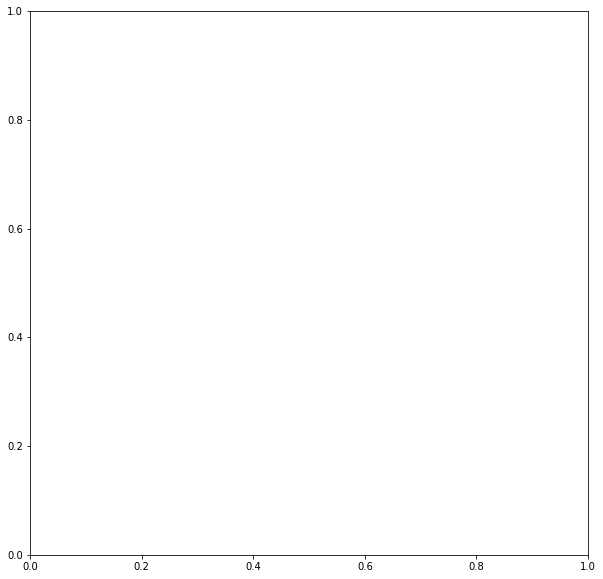

In [27]:
params2 = ParameterServer()

fig = plt.figure(figsize=[10, 10])
viewer = MPViewer(params=params2, center=[5112, 5165], y_length = 120,enforce_y_length=True, axis = fig.gca())
analyzer = BenchmarkAnalyzer(benchmark_result=result_loaded)
configs = analyzer.find_configs(criteria={"behavior": lambda x: x=="IDM", "success": lambda x : not x})
configs_const = analyzer.find_configs(criteria={"behavior": lambda x: x=="Const", "success": lambda x : not x})

analyzer.visualize(configs_idx_list = configs, viewer = viewer, real_time_factor=10, fontsize=12)
                   
#fig, (ax1, ax2) = plt.subplots(1, 2)
        
#viewer1 = MPViewer(params=params2, center=[5112, 5165], y_length = 120, enforce_y_length=True, axis = ax1)
#viewer2 = MPViewer(params=params2, center=[5112, 5165], y_length = 120, enforce_y_length=True, axis = ax2)
#analyzer.visualize(configs_idx_list = [configs[1:3], configs_const[1:3]], viewer = [viewer1, viewer2], viewer_names=["IDM", "ConstVelocity"], real_time_factor=1, fontsize=12)
